# Modelling the response of a Raspberry Pi camera to collimated light

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from extract_raw_image import load_raw_image
import sys
import os
from __future__ import print_function
%matplotlib notebook

In [3]:
data_folder = "./run_3/straight/"

<IPython.core.display.Javascript object>


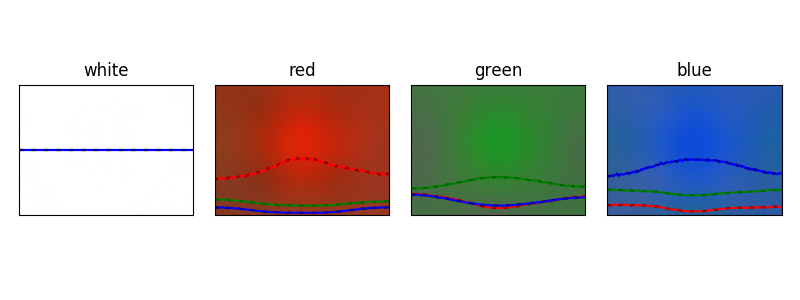

In [46]:
from matplotlib.colors import LinearSegmentedColormap

def bin(image, b=2):
    """Bin bxb squares of an image together"""
    w,h = image.shape[:2]
    new_shape = (w//b, b, h//b, b)
    if len(image.shape) > 2:
        new_shape += image.shape[2:]
    if w % b != 0 or h % b != 0:
        print("Warning: pixels are being dropped from the binned image!")
        image = image[:w - (w%b), :h - (h%b), ...]
    return image.reshape(new_shape).mean(axis=1).mean(axis=2)

illuminations = [(255,255,255), (255,0,0), (0,255,0), (0,0,255)]
binned_images = []

for i, rgb in enumerate(illuminations):
    pi_bayer_array = load_raw_image(os.path.join(data_folder, "capture_r{}_g{}_b{}.jpg".format(*rgb)))
    image = pi_bayer_array.array - np.array([16,32,16])[np.newaxis,np.newaxis,:] # correct for the zero offset in the raw data
    binned_images.append(bin(image, 16))

def wrgb_col_titles(axes):
    for topax, title in zip(axes, ["white", "red", "green", "blue"]):
        topax.set_title(title)
def row_titles(axes, titles):
    for ax, title in zip(axes, titles):
        ax.annotate(title, xy=(0, 0.5), xytext=(0, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='left', va='center', rotation="vertical")
        
def imshow_with_section(ax, image, clip=True):
    """Convert an image to 8 bit and display it in the axes.  Overlay sections through the middle.
    
    if clip==True (default) pixels are constrained to 0-255, to avoid overflow.
    """
    if clip:
        clipped_image = image.copy()
        clipped_image[clipped_image<0] = 0
        clipped_image[clipped_image>255] = 255
    else:
        clipped_image = image
    ax.imshow(clipped_image.astype(np.uint8), origin="bottom")
    x = np.arange(image.shape[1])
    h = image.shape[0]
    for i, col in enumerate(["red","green","blue"]):
        ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color=col)
        ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color="dark"+col, dashes=(2,4))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
norm_white = 255./binned_images[0]

fig, ax = plt.subplots(1, 4, figsize=(8,3))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[i], image*norm_white)
wrgb_col_titles(ax[:])
fig.tight_layout()

In the other notebook, we analysed the RGB images produced under different illuminations, to figure out the effect of the Chief Ray Angle (CRA) compensation.  This results in some empirical correction matrices which are per-pixel (or at least spatially varying).  If we can model this sufficiently well as an effect that is purely geometric, we end up needing far fewer parameters - this might well help us to reduce noise and make calibration easier, or even unnecessary.  It would also be really satisfying to understand where the effect comes from.

A minimal model might consist of light passing first through a Bayer filter, then through a lenslet, then being focused on the light-sensitive area of a pixel.  The offset between light sensitive area and lenslet is probably what varies the most across the sensor.  This means:
* The efficiency will drop off as the light sensitive region moves away from the centre of the lenslets.  The sharpness of this cut-off will be set by the convolution of the focal spot (which may be differently shaped for different wavelengths) and the shape of the light sensitive region.
* Crosstalk will pick up once the focused spot overlaps with adjacent pixels, which have different colour filters on them.  The Bayer pattern probably has a subtle influence on which colours bleed into each other.
* The effect needn't be rotationally symmetric (the pixels are on a square grid - that is not isotropic) but it probably is at least a little bit symmetrical.

The Bayer pattern has twice as many green pixels as red or blue.  This means that each green pixel's four nearest neighboars are two red and two blue, and each R/B pixel has four green nearest neighbours.  If we consider the next-nearest-neighbours (i.e. diagonal), each green pixel has four green neighbours, and each R/B pixel has two each of R and B.

Looking at the uncorrected images from our test camera, the first thing to note is the different rates with which the intensity falls off as we move away from the centre: 

<IPython.core.display.Javascript object>


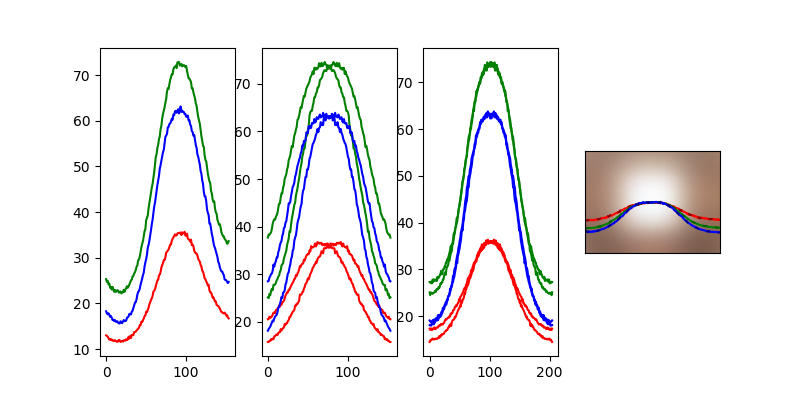

In [16]:
fig, ax = plt.subplots(1,4, figsize=(8,4))
w, h = binned_images[0].shape[:2]
for i, col in enumerate(["red", "green", "blue"]):
    ax[0].plot(np.diagonal(binned_images[i+1][:,:,i]), color=col)
    ax[1].plot(binned_images[i+1][:,h//2,i], color=col)
    ax[1].plot(binned_images[i+1][:,h//2,i][::-1], color=col)
    ax[2].plot(binned_images[i+1][w//2,:,i], color=col)
    ax[2].plot(binned_images[i+1][w//2,:,i][::-1], color=col)
imshow_with_section(ax[3], binned_images[0]/np.max(binned_images[0], axis=(0,1))*255)

<IPython.core.display.Javascript object>


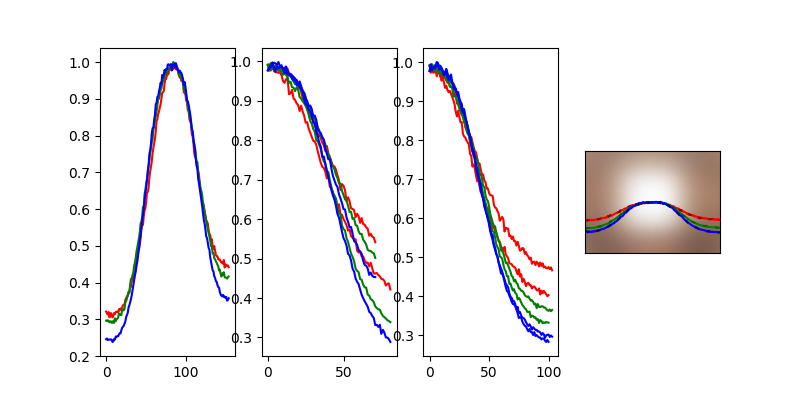

In [33]:
background_subtracted = np.sum(binned_images[0], axis=2)
background_subtracted -= np.max(background_subtracted)*0.9
background_subtracted[background_subtracted < 0] = 0
centroid = scipy.ndimage.measurements.center_of_mass(background_subtracted)
cx, cy = np.round(centroid).astype(int)

fig, ax = plt.subplots(1,4, figsize=(8,4))
w, h = binned_images[0].shape[:2]
for i, col in enumerate(["red", "green", "blue"]):
    m = np.max(binned_images[i+1][:,:,i])
    ax[0].plot(np.diagonal(binned_images[i+1][:,:,i]/m, offset=cy-cx), color=col)
    ax[1].plot(binned_images[i+1][cx:0:-1,cy,i]/m, color=col)
    ax[1].plot(binned_images[i+1][cx::,cy,i]/m, color=col)
    ax[2].plot(binned_images[i+1][cx,cy:0:-1,i]/m, color=col)
    ax[2].plot(binned_images[i+1][cx,cy:,i]/m, color=col)
imshow_with_section(ax[3], binned_images[0]/np.max(binned_images[0], axis=(0,1))*255)

<IPython.core.display.Javascript object>


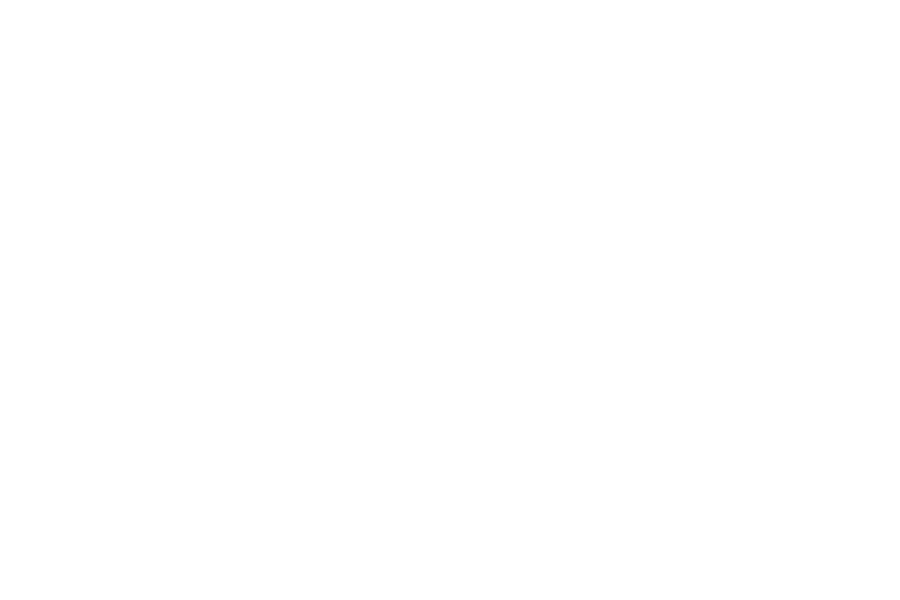

ValueError: Colormap reds is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [41]:
from scipy import stats
x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)
f, ax = plt.subplots(2,3, figsize=(9,6))
density_shape = (int(np.max(r))+5, 100)
density_grid = np.meshgrid(np.arange(density_shape[0]), 
                           np.linspace(0,1.05,density_shape[1]), indexing='ij')
density_coords = np.vstack([d.ravel() for d in density_grid])

if False: #for i, col in enumerate(["red", "green", "blue"]): # doesn't currently work...
    channel = binned_images[i+1][:,:,i]
    channel /= np.max(channel)
    ax[0,i].plot(np.ravel(r), np.ravel(channel), '.', color=col)
    kde = stats.gaussian_kde(np.vstack([r.ravel(), channel.ravel()]))
    density = kde(density_coords).reshape(density_shape)
    ax[1,i].imshow(density, cmap=col+'s')

# Radial symmetry
The most naiive assumption would be that the effect only depends on the angle between the designed incidence of the ray and the actual incident angle (assumed here to be constant across the sensor).  This probably ought to be radially symmetric (at least until you account for the pixel grid, etc. etc.).  We can test this hypothesis by plotting the intensity vs radius - the top plots do this directly, the bottom plots are histograms of the same thing, which show the distribution more clearly.

<IPython.core.display.Javascript object>


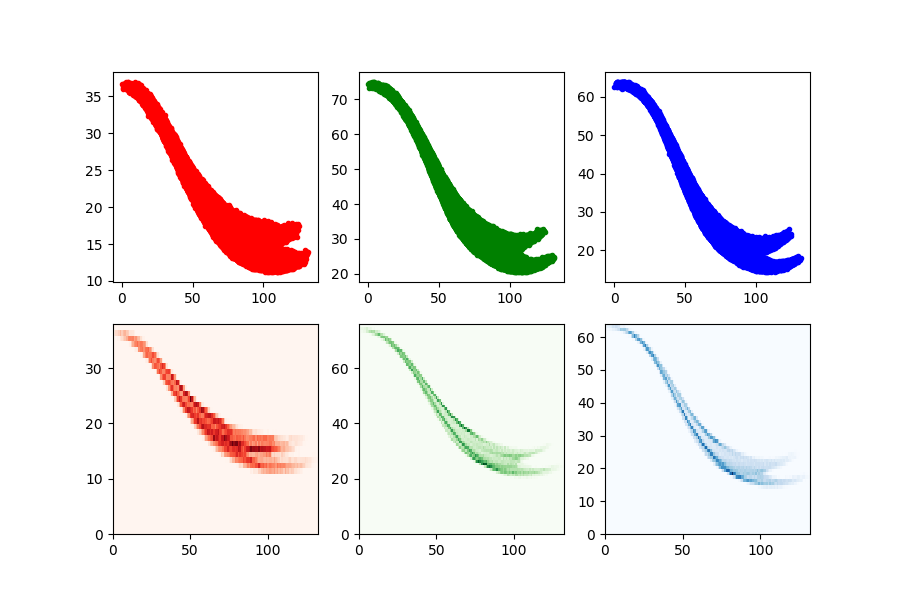

In [47]:
from scipy import stats
x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)
f, ax = plt.subplots(2,3, figsize=(9,6))

for i, col in enumerate(["red", "green", "blue"]):
    channel = binned_images[i+1][:,:,i]
    ax[0,i].plot(np.ravel(r), np.ravel(channel), '.', color=col)
    
    density, xe, ye = np.histogram2d(r.ravel(), channel.ravel(), 
                                     (np.arange(np.max(r)+1), np.arange(np.max(channel)+1)))
    ax[1,i].pcolormesh(xe, ye, density.T, cmap=col.capitalize()+"s")

If we take radial symmetry (about the maximum rather than about the centre) as our model, we can look at the residuals as a 2D image - this seems to suggest that the problem is just that it's bright at the bottom.  This is the axis along which I'd be most likely to suspect stray light, but it's also the one where you'd be most likely to get electrical effects, I think.  Should repeat the experiment in the dark, with the camera tilted, with the camera flipped 180 degrees.

<IPython.core.display.Javascript object>


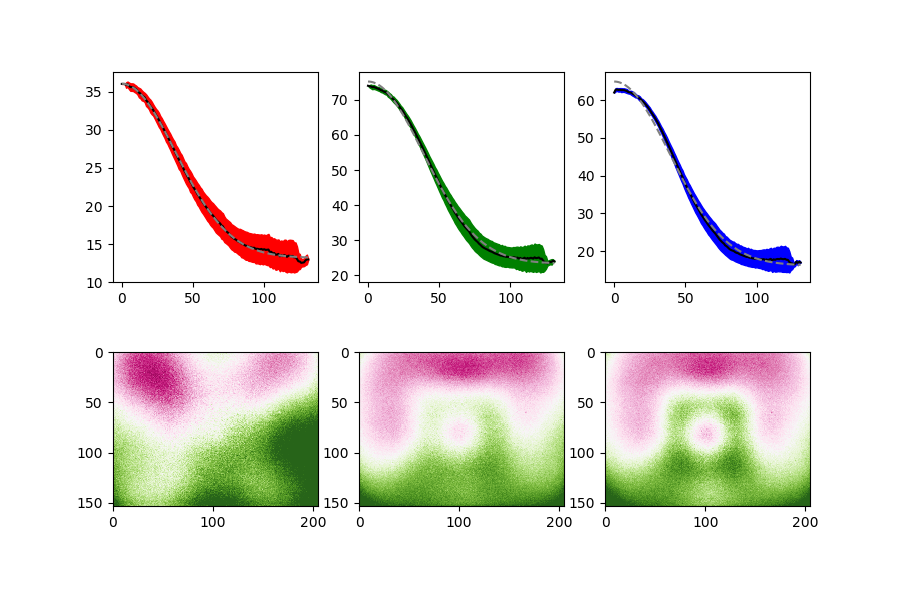

In [81]:
from scipy import optimize

f, ax = plt.subplots(2,3, figsize=(9,6))

def gaussian(x, sd, peak, background):
    """A 1D Gaussian centred on the origin"""
    return np.exp(-x**2/2/sd**2)*(peak - background) + background

for i, col in enumerate(["red", "green", "blue"]):
    channel = binned_images[i+1][:,:,i]
    density, xe, ye = np.histogram2d(r.ravel(), channel.ravel(), 
                                     (np.arange(np.max(r)+1), np.arange(np.max(channel)+1)))
    I = np.arange(density.shape[1])[np.newaxis,:]
    mean_i_vs_r = np.sum(density * I, axis=1)/np.sum(density, axis=1)
    sd_i_vs_r = np.sqrt(np.sum(density * (I - mean_i_vs_r[:,np.newaxis])**2, axis=1)/np.sum(density, axis=1))
    ax[0,i].fill_between(np.arange(len(mean_i_vs_r)), mean_i_vs_r - sd_i_vs_r, mean_i_vs_r + sd_i_vs_r, color=col)
    ax[0,i].plot(mean_i_vs_r, color="black")
    
    fitx = np.arange(len(mean_i_vs_r), dtype=np.float)
    popt, pcov = optimize.curve_fit(gaussian, fitx, mean_i_vs_r, (40, mean_i_vs_r.max(), 0))
    
    ax[0,i].plot(fitx, gaussian(fitx, *popt), '--', color="gray")
    
    model = np.interp(r.ravel(), np.arange(len(mean_i_vs_r)), mean_i_vs_r).reshape(r.shape)
    model = np.interp(r.ravel(), np.arange(len(mean_i_vs_r)), gaussian(fitx, *popt)).reshape(r.shape)
    im = ax[1,i].imshow((channel - model)/np.max(model), cmap="PiYG", vmin=-0.08, vmax=0.08)
#plt.colorbar(im)

The Gaussian fit looks really good on the red channel, but it's much less convincing on green and blue.  I wonder if what we need is the convolution of a square and a gaussian?  That would fit with the model of a focal spot shifting around on a square pixel...

<IPython.core.display.Javascript object>


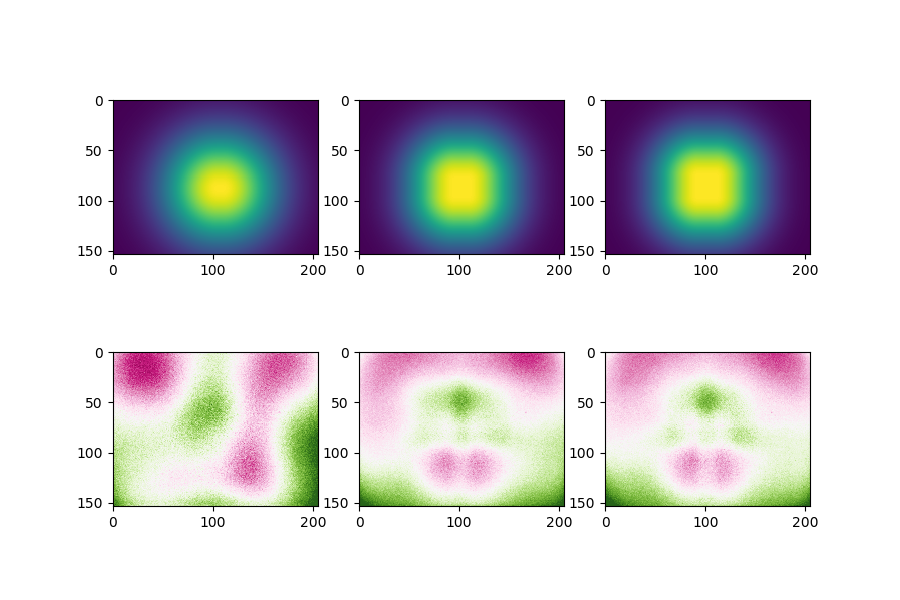

Optimal parameters: SD 38.1969551091, square 4.0365339482e-22x4.14653405254, peak 36.0215885906, background 13.661917125, centre (87.892975647,106.167157961)
Optimal parameters: SD 33.3708103771, square 14.9872481037x13.0444171725, peak 72.7957168373, background 24.8028442804, centre (87.2365917271,101.619654696)
Optimal parameters: SD 31.3669555559, square 19.5177765605x17.0648026194, peak 62.4536334256, background 18.0307697678, centre (86.0667962628,100.849869406)


In [83]:
from scipy import optimize

x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)

def gaussian(x, y, sd, sw, sh, peak, background, cx=cx, cy=cy):
    """A 1D Gaussian centred on the origin"""
    dx = np.abs(x - cx) - sw/2
    dx[dx < 0] = 0
    dy = np.abs(y - cy) - sh/2
    dy[dy < 0] = 0
    return np.exp(-(dx**2 + dy**2)/2/sd**2)*(peak - background) + background
           
def residuals_for(channel):
    def residuals(p):
        return ((channel - gaussian(x, y, *p))**2).ravel()
    return residuals

f, ax = plt.subplots(2,3, figsize=(9,6))
for i, col in enumerate(["red", "green", "blue"]):
    channel = binned_images[i+1][:,:,i]
    
    res = optimize.least_squares(residuals_for(channel), 
                                 (40, 0, 0, channel.max(), 0, cx, cy),
                                 bounds=((0, 0, 0, 0, 0, 0, 0),
                                         (np.inf, w, h, np.inf, np.inf, w, h)))
    popt = res.x
    print("Optimal parameters: SD {}, square {}x{}, peak {}, background {}, centre ({},{})".format(*popt))
    
    ax[0,i].imshow(gaussian(x, y, *popt))
    im = ax[1,i].imshow((channel - gaussian(x, y, *popt))/np.max(channel), cmap="PiYG", vmin=-0.08, vmax=0.08)